In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import random
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import pickle
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate,train_test_split,KFold
from surprise import SVD,SVDpp, NMF,SlopeOne,CoClustering
from surprise import accuracy
from collections import defaultdict

my_seed = 0
random.seed(my_seed)

Now we import the user recipe interaction data to build the recommender base on user interaction

In [2]:
interactions = pd.read_csv('../data-recipes/RAW_interactions.csv')
# recipes = pd.read_pickle('data/raw_df.pkl')
recipes = pd.read_csv('../data-recipes/RAW_recipes.csv')

In [3]:
interactions.head()

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [4]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [5]:
def make_df_from_count(serie,name):
    counts = dict(Counter(serie))
    return pd.DataFrame.from_dict(counts,orient='index').reset_index().rename(columns={'index':name,0:f'{name}_count'})

In [6]:
recipe_df = make_df_from_count(interactions.recipe_id,'recipe_id')
recipe_df.head()

,recipe_id,recipe_id_count
0,40893,2
1,44394,1
2,85009,2
3,120345,3
4,134728,7


In [7]:
len(recipe_df[recipe_df['recipe_id_count'] <2])/len(recipe_df)

0.39697025950085696

In [8]:
len(recipe_df[recipe_df['recipe_id_count'] <10])/len(recipe_df) 

0.9076183856637756

Most of the recipes (39%) has only one review. Majority of them has less than 10 reviews (~90%)..
Shall I remove some items so to avoid a matrix too sparse?

What about user behavior?

In [9]:
user_df = make_df_from_count(interactions.user_id,'user_id')
user_df.head()

,user_id,user_id_count
0,38094,35
1,1293707,48
2,8937,31
3,126440,1950
4,57222,442


(0.0, 50.0)

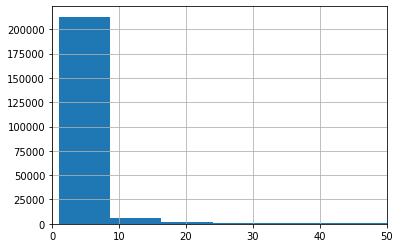

In [10]:
user_df['user_id_count'].hist(bins=1000)
ax = plt.gca()
ax.set_xlim((0,50))

In [11]:
len(user_df)

226570

Most users (94%) do not have more than 10 reviews

In [12]:
len(user_df[user_df.user_id_count <10])/len(user_df)

0.944891203601536

We observe that the histrogram shows quite a right tail and there are very popular recipes

We would like to remove the recipes that have only 1 reviews

In [13]:
interactions.recipe_id.unique()

array([ 40893,  44394,  85009, ..., 257796,  72730, 386618])

In [14]:
interactions_merge = interactions.merge(recipe_df,how='left',left_on='recipe_id',right_on = 'recipe_id')

In [15]:
interactions_merge.head()

,user_id,recipe_id,date,rating,review,recipe_id_count
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...,2
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall...",2
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...,1
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...,2
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin...",2


In [16]:
df_UI = pd.DataFrame(interactions_merge[['user_id','recipe_id','rating']])

In [17]:
def id_transformation(values):
    unique_values = np.unique(values)
    return dict([(x, y) for y, x in enumerate(unique_values)])

In [18]:
user_id_transformed = id_transformation(df_UI.user_id)
recipe_id_transformed = id_transformation(df_UI.recipe_id)

In [19]:
transformed_user_id = pd.DataFrame.from_dict(user_id_transformed,orient = 'index').reset_index().rename(columns={'index':'user_id',0:'new_user_id'})
transformed_recipe_id = pd.DataFrame.from_dict(recipe_id_transformed,orient = 'index').reset_index().rename(columns={'index':'recipe_id',0:'new_recipe_id'})

In [20]:
df_UI_new = df_UI.merge(transformed_user_id, how = 'left' ,left_on = 'user_id',right_on='user_id').merge(transformed_recipe_id, how = 'left' ,left_on = 'recipe_id',right_on='recipe_id')

In [21]:
df_UI_new.head()

,user_id,recipe_id,rating,new_user_id,new_recipe_id
0,38094,40893,4,3935,22741
1,1293707,40893,5,99667,22741
2,8937,44394,4,577,24831
3,126440,85009,5,15027,48726
4,57222,85009,5,6799,48726


In [22]:
shape = (len(transformed_user_id),len(transformed_recipe_id))

In [23]:
UI_mtx = coo_matrix ((df_UI_new.rating,(df_UI_new.new_user_id,df_UI_new.new_recipe_id)),shape = shape)

In [24]:
UI_mtx.shape

(226570, 231637)

In [25]:
final_UI_mtx = df_UI_new.drop(columns=['user_id', 'recipe_id'])
final_UI_mtx.head()

,rating,new_user_id,new_recipe_id
0,4,3935,22741
1,5,99667,22741
2,4,577,24831
3,5,15027,48726
4,5,6799,48726


Save all the intermediate data for further use

In [26]:
def save_file_to_pickle(item, file_name, file_type = 'obj'):
    file = open(f'output/{file_name}.{file_type}', 'wb') 
    pickle.dump(item, file)
    file.close()

In [27]:
recipes = recipes.merge(transformed_recipe_id, how = 'left' ,left_on = 'id',right_on='recipe_id')

In [28]:
recipes = recipes.drop(columns=['recipe_id','id'])

In [29]:
recipes.head()

,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,new_recipe_id
0,arriba baked winter squash mexican style,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,79681
1,a bit different breakfast pizza,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,17031
2,all in the kitchen chili,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,65277
3,alouette potatoes,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,33775
4,amish tomato ketchup for canning,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,24632


In [30]:
# save_file_to_pickle(final_UI_mtx,"UI_mtx",'pkl')

In [31]:
# save_file_to_pickle(recipes,"recipes",'pkl')

In [32]:
final_UI_mtx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1132367 entries, 0 to 1132366
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype
---  ------         --------------    -----
 0   rating         1132367 non-null  int64
 1   new_user_id    1132367 non-null  int64
 2   new_recipe_id  1132367 non-null  int64
dtypes: int64(3)
memory usage: 34.6 MB


We will use surprise for the model so we need to treat the data as per requirement

In [33]:
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(final_UI_mtx[['new_user_id', 'new_recipe_id', 'rating']], reader)

In [34]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [35]:
# We'll use the famous SVD algorithm.
algo = SVD(verbose=True)

In [36]:
def kfold_train_test(data,algo,kfold = 5,k = 10,treshold = 3.5):
    kf = KFold(n_splits=kfold)
    precision_kfold = []
    recall_kfold = []

    for trainset, testset in kf.split(data):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=treshold)

        # Precision and recall can then be averaged over all users
        precision_kfold.append(sum(prec for prec in precisions.values()) / len(precisions))
        recall_kfold.append(sum(rec for rec in recalls.values()) / len(recalls))
        
    return precision_kfold,recall_kfold

In [37]:
# kfold_train_test(data)

In [38]:
kf = KFold(n_splits=5)
precision_kfold = []
recall_kfold = []

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=3.5)

    # Precision and recall can then be averaged over all users
    precision_kfold.append(sum(prec for prec in precisions.values()) / len(precisions))
    recall_kfold.append(sum(rec for rec in recalls.values()) / len(recalls))

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing

In [39]:
print("5-fold precision@10 is {:.3f}".format(np.mean(precision_kfold)),"\n","5-fold recall@10 is {:.3f}".format(np.mean(recall_kfold)))

5-fold precision@10 is 0.812 
 5-fold recall@10 is 0.963


In [40]:
# save_file_to_pickle(algo,"SVD_algo",'pkl')

In [41]:
uid = 226571
iids =[23,56,34,111]
recipes_names = dict([(rep_id,name) for name,rep_id in zip(recipes.name,recipes.new_recipe_id)])

In [42]:
def pretty_text (text):
    ''' This function takes in text and try to put it in a human readable format by putting back \' and making it capitalize
    '''
    text = text.replace(" s ","\'s ")
    text_split = text.split(" ")
    #print(text_split)
    text_split = [t.strip().capitalize() for t in text_split if t != '']
    #print(text_split)
    return " ".join(text_split)

In [43]:
[pretty_text(recipes_names[r]) for r in iids]

['Butter Madeira Cake',
 'Cheese Rolls',
 'Chicken Breasts Saltimbocca',
 'Swiss Crab Melt']

In [44]:
# save_file_to_pickle(recipes_names,"recipes_names",'pkl')

In [45]:
def get_n_predictions(iids,algo,n = 10, uid = 226571, item_name = recipes_names):
    
    # create the list to search in
    iid_to_test = [iid for iid in range(231637) if iid not in iids]
    # build data for surprise
    test_set = [[uid,iid,4.] for iid in iid_to_test]
    # predict
    predictions = algo.test(test_set)
    #get prediction
    pred_ratings = [pred.est for pred in predictions]
    # return top_n indexes
    top_n = np.argpartition(pred_ratings,1)[-n:]
    # return list of recipe names
    results = [item_name[k] for k in top_n]
    
    return [pretty_text(r) for r in results]

In [46]:
get_n_predictions(iids,algo)

['Rapid Rise Skillet Yeast Rolls',
 'Carrot Apple Zucchini Bread',
 'Poinsettia Pull Apart Cookies',
 'Pumpkin Spice Granola',
 "Campbell's Mini Green Bean Casseroles",
 'Copycat Chick Fil A Spicy Deluxe Chicken Sandwich',
 'One Pan No Peek Chicken And Rice',
 'Red Wine Braised Short Ribs With Fingerlings Potatoes',
 'Garlic And Herb Mashed Potatoes',
 "Bailey's Chocotini"]

In [47]:
n=10
# create the list to search in
iid_to_test = [iid for iid in range(231637) if iid not in iids]
# build data for surprise
test_set = [[uid,iid,4.] for iid in iid_to_test]
# predict
predictions = algo.test(test_set)
#get prediction
pred_ratings = [pred.est for pred in predictions]
# return top_n indexes
top_n = np.argpartition(pred_ratings,1)[-n:]
# return list of recipe names
results = [recipes_names[k] for k in top_n]

print( [pretty_text(r) for r in results] )

['Rapid Rise Skillet Yeast Rolls', 'Carrot Apple Zucchini Bread', 'Poinsettia Pull Apart Cookies', 'Pumpkin Spice Granola', "Campbell's Mini Green Bean Casseroles", 'Copycat Chick Fil A Spicy Deluxe Chicken Sandwich', 'One Pan No Peek Chicken And Rice', 'Red Wine Braised Short Ribs With Fingerlings Potatoes', 'Garlic And Herb Mashed Potatoes', "Bailey's Chocotini"]


In [48]:
# We'll use the famous SVD algorithm.
algo2 = SVDpp(verbose=True) # we skip this because it is too time consuming for our data... unless we test on a small set of it

In [49]:
algo2 = NMF()

In [50]:
# we will try slopeone
algo3 = CoClustering(n_cltr_i= 6,verbose = False)

In [51]:
precision_kfold,recall_kfold = kfold_train_test(algo = algo3,data = data)

In [52]:
print("5-fold precision@10 is {:.3f}".format(np.mean(precision_kfold)),"\n","5-fold recall@10 is {:.3f}".format(np.mean(recall_kfold)))

5-fold precision@10 is 0.819 
 5-fold recall@10 is 0.928
